## Neural Network

This jupyter notebook implements the neural network model using convolutional layers

In [142]:
#Import libraries
from torchvision.io import read_image
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torch 
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer
import os
from torch.optim.lr_scheduler import ExponentialLR, StepLR
from sklearn.metrics import recall_score, accuracy_score, f1_score
import numpy as np
from XRayDataset import XRayDataset
from dataloader import train_path, test_path, val_path
import matplotlib.pylab as plt
import copy
%matplotlib inline

In [143]:
class CustomNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.LeNet = nn.Sequential(
            nn.Sequential(
                nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
                nn.BatchNorm2d(6),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ),
            nn.Sequential(
                nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ),
            nn.Flatten(),
            nn.Linear(16 * 61 * 61, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 2)
        )

    def forward(self, x):
        out = self.LeNet(x)
        return out


In [144]:
model = CustomNeuralNetwork()

In [145]:
#Dataloader code from Checkpoint #1
resize = T.Compose([
            T.ToPILImage(), 
            T.Grayscale(num_output_channels=1),
            T.Resize((int(256), int(256))), # Resize the image to match median ratio using median length, we can try later with smaller length 
            T.ToTensor()
        ])
 
# transforms = T.Compose([
#             T.ToPILImage(), 
#             T.Grayscale(num_output_channels=1),
#             T.RandomAdjustSharpness(sharpness_factor=10),
#             T.ColorJitter(brightness=.5, hue=.3),
#             T.Resize((int(256), int(256))),
#             # Resize the image to match median ratio using median length 
#             T.ToTensor()
#         ])

transforms = T.Compose([
    T.ToPILImage(),
    T.Grayscale(num_output_channels=1),
    T.Resize((256, 256)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5])
])

training_data = XRayDataset(train_path, transforms)
val_data = XRayDataset(val_path, resize)
test_data = XRayDataset(test_path, resize)


# article on batch sizes 
#https://medium.com/data-science-365/determining-the-right-batch-size-for-a-neural-network-to-get-better-and-faster-results-7a8662830f15

batch_s = 8

train_dataloader = DataLoader(training_data, batch_size=batch_s, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_s, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_s, shuffle=True)


In [146]:
# 3: Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler_lr = StepLR(optimizer, 
                   step_size = 4, # Period of learning rate decay
                   gamma = 0.5)

scheduler_eilr = ExponentialLR(optimizer, 
                          gamma = 0.5) # Multiplicative factor of learning rate decay.

EPOCHS = 20

In [147]:
# 4: Train and validate the network
train_losses = []
train_accuracies = []
train_recalls = []
val_accuracies = []
val_recalls = []
for _ in range(EPOCHS):
    # TRAIN
    model.train()  # Make sure gradient tracking is on, and do a pass over the data
    running_loss = 0.0
    y_true = np.array([])
    y_predict = np.array([])
    for i, data in enumerate(train_dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        optimizer.zero_grad()  # zero the parameter gradients
        outputs = model(inputs)  # forward pass
        label_dict = {"PNEUMONIA": 0, "NORMAL": 1}
        labels_tensor = torch.tensor([label_dict[label] for label in labels])
        loss = criterion(outputs, labels_tensor)  # calculate loss
        loss.backward()  # backward pass
        optimizer.step()  # update weights
        running_loss += loss.item()
        y_true = np.concatenate((y_true, labels_tensor.numpy()))
        y_pred_batch = np.argmax(outputs.detach().numpy(), axis=1)
        y_predict = np.concatenate((y_predict, y_pred_batch))
    
    epoch_accuracy = (y_predict == y_true).mean()
    epoch_recall = recall_score(y_true, y_predict, average='binary')
    train_losses.append(running_loss)
    train_accuracies.append(epoch_accuracy)
    train_recalls.append(epoch_recall)

    #VALIDATION
    with torch.no_grad():
        model.eval() 

         # # we don't want to keep track of the gradients in the validation part
        y_true_val = np.array([])
        y_predict_val = np.array([])
        for i, data in enumerate(val_dataloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            outputs = model(inputs)  # forward pass
            label_dict = {"PNEUMONIA": 0, "NORMAL": 1}
            labels_tensor = torch.tensor([label_dict[label] for label in labels])
            y_true_val = np.concatenate((y_true_val, labels_tensor.numpy()))
            y_predict_val = np.concatenate((y_predict_val, outputs.argmax(dim=1).numpy()))

        val_epoch_accuracy = (y_predict_val == y_true_val).mean()
        val_epoch_recall = recall_score(y_true_val, y_predict_val, average='binary')
        val_losses.append(val_running_loss)
        val_accuracies.append(val_epoch_accuracy)
        val_recalls.append(val_epoch_recall)



In [148]:
# y_predict, y_true, train_losses, train_accuracies, train_recalls = train(model)
print("y_predict", y_predict)
print("y_true", y_true)
print(train_losses)
print("Training accuracies",train_accuracies)
print(train_recalls)

print("Validation accuracies",val_accuracies)
print(val_recalls)

y_predict [0. 1. 0. ... 1. 1. 0.]
y_true [0. 1. 0. ... 1. 1. 0.]
[175.78084494784707, 110.06877952901414, 95.26449446717743, 85.96957529665087, 80.92476645825082, 79.79252029117197, 74.28009848462534, 71.98245610851154, 66.76119909685804, 65.08071047745761, 64.47449520505324, 60.15661554274266, 55.409815428662114, 58.386302130369586, 54.22577663887205, 50.4661070137372, 51.502856187624275, 48.954131901255096, 49.197448142607755, 49.56767523360759]
Training accuracies [0.8876533742331288, 0.9336656441717791, 0.9432515337423313, 0.9491947852760736, 0.9543711656441718, 0.9524539877300614, 0.9547546012269938, 0.9582055214723927, 0.9612730061349694, 0.95954754601227, 0.9626150306748467, 0.9666411042944786, 0.9674079754601227, 0.9637653374233128, 0.96875, 0.9704754601226994, 0.9672162576687117, 0.9718174846625767, 0.9723926380368099, 0.968558282208589]
[0.7255779269202088, 0.866517524235645, 0.8866517524235645, 0.889634601043997, 0.9075316927665921, 0.9000745712155108, 0.9052945563012678, 0.

In [149]:
# # 4: Train and validate the network
# val_losses = []
# val_accuracies = []
# val_recalls = []
# with torch.no_grad():
#     model.eval() 
#     for _ in range(EPOCHS):
#     # VAL
#          # # we don't want to keep track of the gradients in the validation part
#         y_true_val = np.array([])
#         y_predict_val = np.array([])
#         for i, data in enumerate(val_dataloader):
#             # get the inputs; data is a list of [inputs, labels]
#             inputs, labels = data
#             outputs = model(inputs)  # forward pass
#             label_dict = {"PNEUMONIA": 0, "NORMAL": 1}
#             labels_tensor = torch.tensor([label_dict[label] for label in labels])
#             y_true_val = np.concatenate((y_true_val, labels_tensor.numpy()))
#             y_predict_val = np.concatenate((y_predict_val, outputs.argmax(dim=1).numpy()))

#         val_epoch_accuracy = (y_predict_val == y_true_val).mean()
#         val_epoch_recall = recall_score(y_true_val, y_predict_val, average='binary')
#         val_losses.append(val_running_loss)
#         val_accuracies.append(val_epoch_accuracy)
#         val_recalls.append(val_epoch_recall)

In [150]:
print(val_accuracies)
print(val_recalls)

unique, counts = np.unique(y_predict_val, return_counts=True)

# print the unique values and their counts
for value, count in zip(unique, counts):
    print(f"{value}: {count}")

[0.5625, 0.5, 0.625, 0.625, 0.5625, 0.5625, 0.5625, 0.625, 0.5625, 0.625, 0.5625, 0.5625, 0.5625, 0.5625, 0.9375, 0.5625, 0.625, 0.5625, 0.8125, 0.5625]
[0.125, 0.0, 0.25, 0.25, 0.125, 0.125, 0.125, 0.25, 0.125, 0.25, 0.125, 0.125, 0.125, 0.125, 1.0, 0.125, 0.25, 0.125, 0.625, 0.125]
0.0: 15
1.0: 1


In [151]:
#5. Test model
test_losses = []
test_accuracies = []
test_recalls = []
with torch.no_grad():
    model.eval()
    y_true_test = np.array([])
    y_predict_test = np.array([])
    for i, data in enumerate(test_dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        outputs = model(inputs)  # forward pass
        label_dict = {"PNEUMONIA": 0, "NORMAL": 1}
        labels_tensor = torch.tensor([label_dict[label] for label in labels])
        y_true_test = np.concatenate((y_true_test, labels_tensor.numpy()))
        y_predict_test = np.concatenate((y_predict_test, outputs.argmax(dim=1).numpy()))

    test_epoch_accuracy = (y_predict_test == y_true_test).mean()
    test_epoch_recall = recall_score(y_true_test, y_predict_test, average='binary')
    test_losses.append(test_running_loss)
    test_accuracies.append(test_epoch_accuracy)
    test_recalls.append(test_epoch_recall)

In [152]:
print("accuracy", test_accuracies)
print("recall", test_recalls)

unique, counts = np.unique(y_predict_test, return_counts=True)

# print the unique values and their counts
for value, count in zip(unique, counts):
    print(f"{value}: {count}")


accuracy [0.6314102564102564]
recall [0.017094017094017096]
0.0: 620
1.0: 4


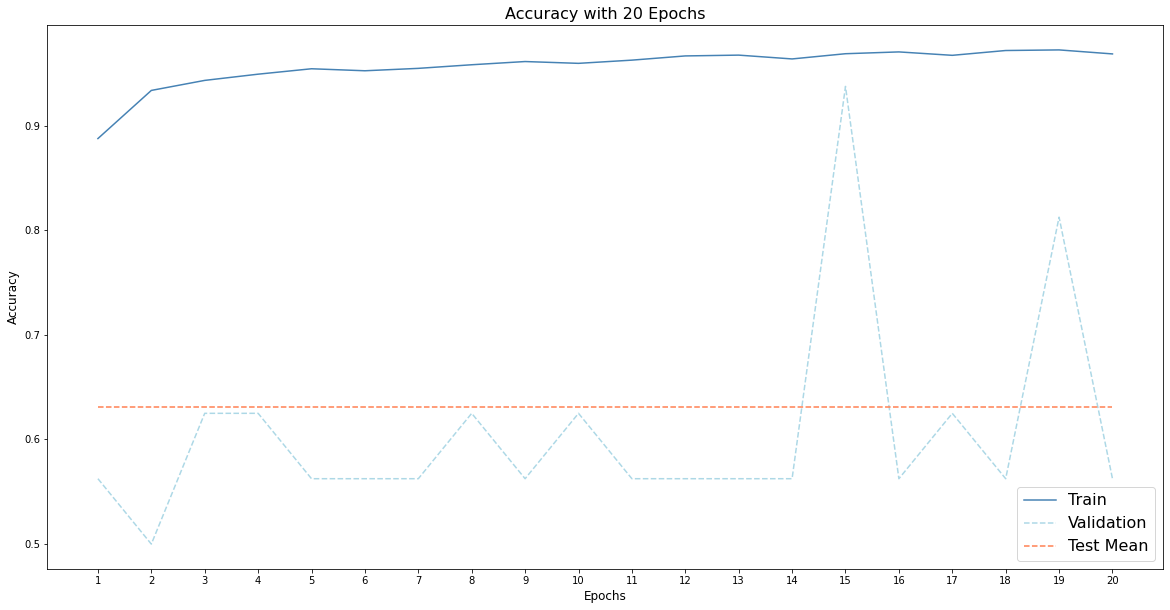

In [153]:
test_accuracy =  test_accuracies * EPOCHS  
epochs = [i for i in range(1,EPOCHS+1)]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax.plot(epochs, train_accuracies, color="steelblue", label= 'Train')
ax.plot(epochs, val_accuracies, color="lightblue", ls='dashed', label='Validation')
ax.plot(epochs, test_accuracy, color= "coral", ls='dashed', label='Test Mean')
ax.set_xticks(epochs)
ax.legend(loc="lower right", fontsize=16)
ax.set_xlabel("Epochs", fontsize=12)
ax.set_ylabel("Accuracy", fontsize=12)
ax.set_title("Accuracy with 20 Epochs", fontsize=16)
plt.show()

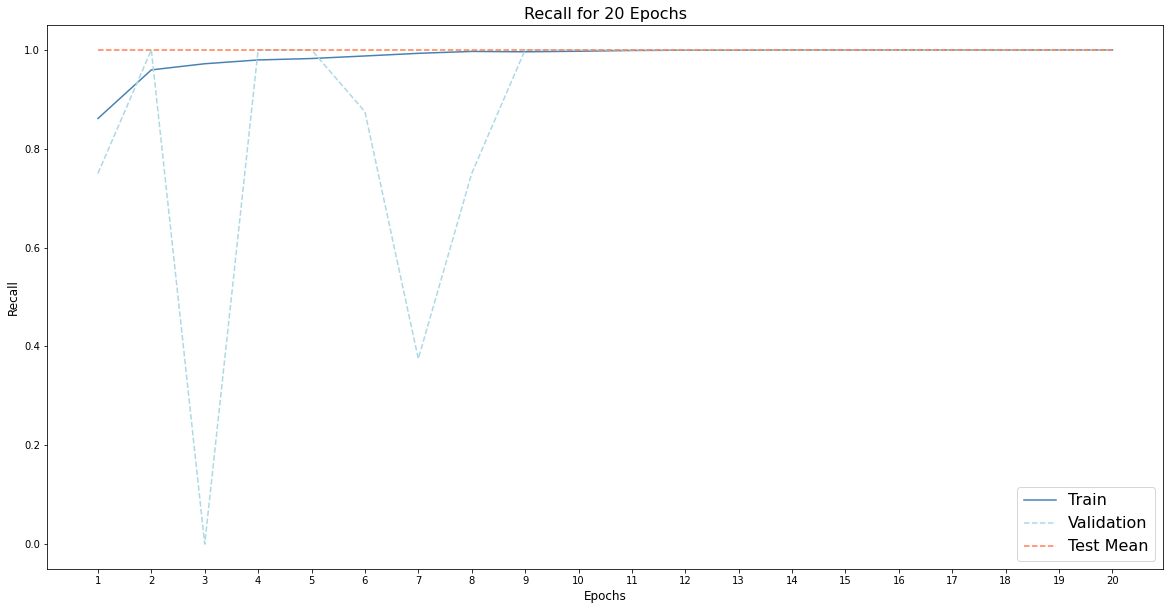

In [154]:
train_recall_20 = [0.8611963190184049, 0.95954754601227, 0.9720092024539877, 0.9796779141104295, 0.9825536809815951, 0.9877300613496932, 0.9930981595092024, 0.9969325153374233, 0.9961656441717791, 0.9973159509202454, 0.9988496932515337, 0.9994248466257669, 0.9994248466257669, 1.0, 0.999808282208589, 1.0, 1.0, 0.999808282208589, 1.0, 1.0]
val_recall_20 = [0.75, 1.0, 0.0, 1.0, 1.0, 0.875, 0.375, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
test_recall_20 = [1.0] * 20
epochs = [i for i in range(1,20+1)]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax.plot(epochs, train_recall_20, color="steelblue", label= 'Train')
ax.plot(epochs, val_recall_20, color="lightblue", ls='dashed', label='Validation')
ax.plot(epochs, test_recall_20, color= "coral", ls='dashed', label='Test Mean')
ax.set_xticks(epochs)
ax.legend(loc="lower right", fontsize=16)
ax.set_xlabel("Epochs", fontsize=12)
ax.set_ylabel("Recall", fontsize=12)
ax.set_title("Recall for 20 Epochs", fontsize=16)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (5,) and (20,)

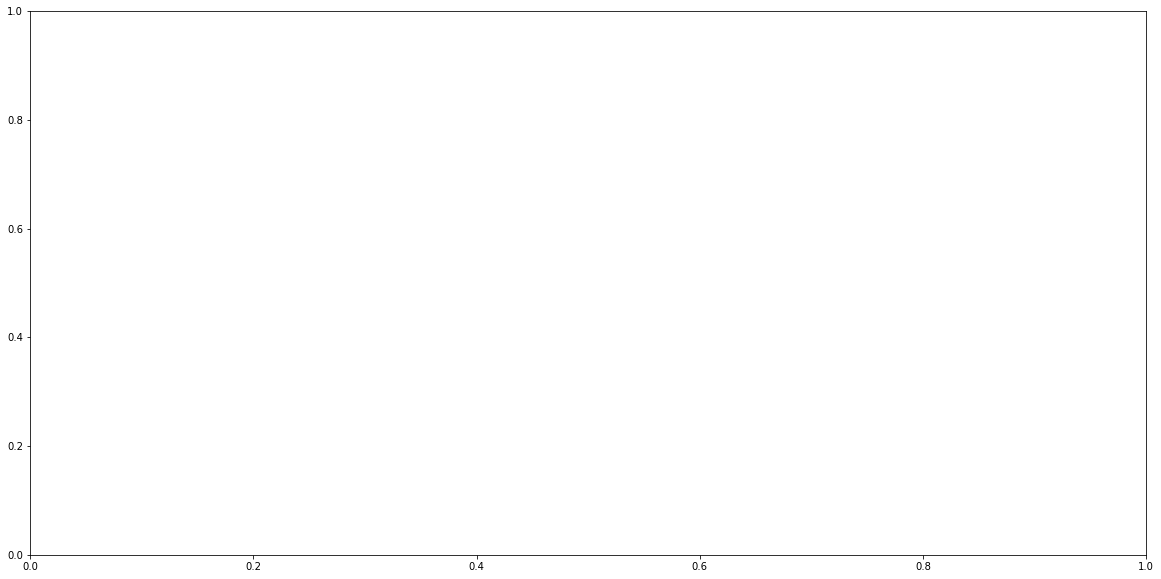

In [155]:
epochs = [i for i in range(1,5+1)]
train_accuracies_5 = copy.deepcopy(train_accuracies)
val_accuracies_5 = copy.deepcopy(val_accuracies)
test_accuracies_5 = copy.deepcopy(test_accuracies) * 5 

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax.plot(epochs, train_accuracies_5, color="steelblue", label= 'Train')
ax.plot(epochs, val_accuracies_5, color="lightblue", ls='dashed', label='Validation')
ax.plot(epochs, test_accuracies_5, color= "coral", ls='dashed', label='Test Mean')
ax.set_xticks(epochs)
ax.legend(loc="lower right", fontsize=16)
ax.set_xlabel("Epochs", fontsize=12)
ax.set_ylabel("Accuracy", fontsize=12)
ax.set_title("Accuracy with {} Epochs".format(EPOCHS), fontsize=16)
plt.show()

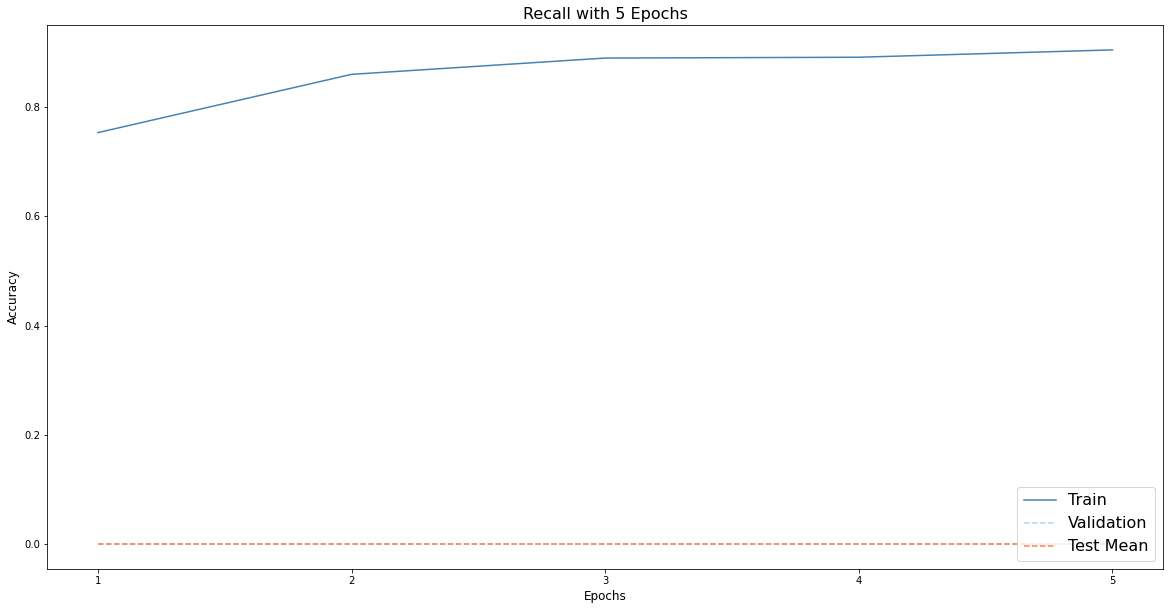

In [ ]:
epochs = [i for i in range(1,5+1)]
train_recalls_5 = copy.deepcopy(train_recalls)
val_recalls_5 = copy.deepcopy(val_recalls)
test_recalls_5 = copy.deepcopy(test_recalls) * 5 

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax.plot(epochs, train_recalls_5, color="steelblue", label= 'Train')
ax.plot(epochs, val_recalls_5, color="lightblue", ls='dashed', label='Validation')
ax.plot(epochs, test_recalls_5, color= "coral", ls='dashed', label='Test Mean')
ax.set_xticks(epochs)
ax.legend(loc="lower right", fontsize=16)
ax.set_xlabel("Epochs", fontsize=12)
ax.set_ylabel("Accuracy", fontsize=12)
ax.set_title("Recall with 5 Epochs", fontsize=16)
plt.show()

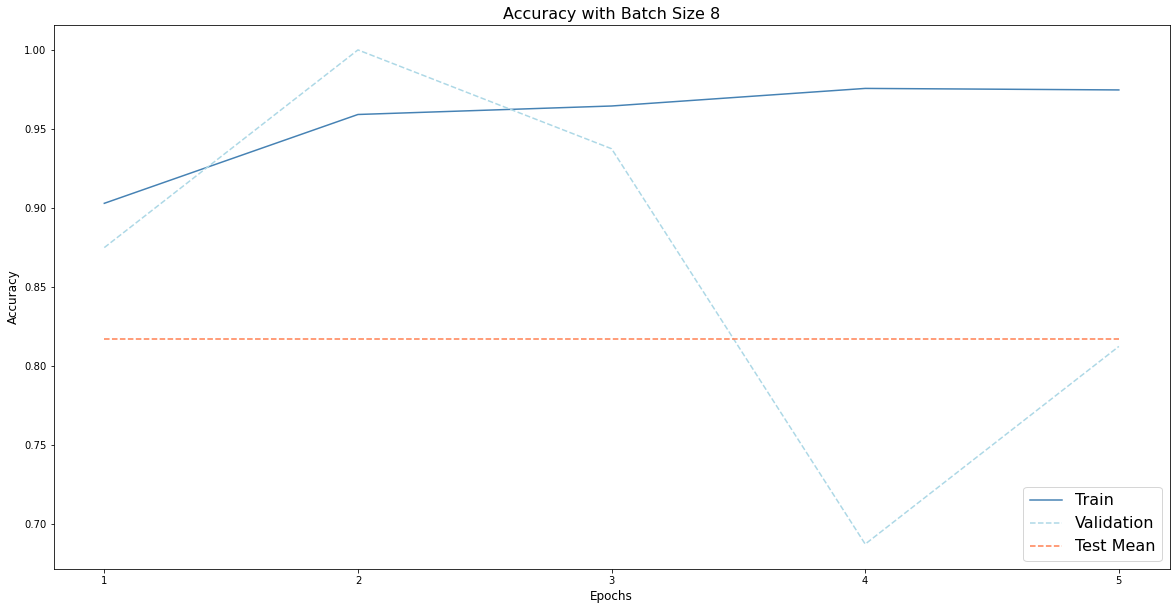

In [ ]:
train_accuracies_batch_8 = [0.9029907975460123, 0.9591641104294478, 0.964532208588957, 0.9756518404907976, 0.9746932515337423]
val_accuracies_batch_8 = [0.875, 1.0, 0.9375, 0.6875, 0.8125]
test_accuracies_batch_8 = [0.8173076923076923] * 5 
epochs = [i for i in range(1,5+1)]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax.plot(epochs, train_accuracies_batch_8, color="steelblue", label= 'Train')
ax.plot(epochs, val_accuracies_batch_8, color="lightblue", ls='dashed', label='Validation')
ax.plot(epochs, test_accuracies_batch_8, color= "coral", ls='dashed', label='Test Mean')
ax.set_xticks(epochs)
ax.legend(loc="lower right", fontsize=16)
ax.set_xlabel("Epochs", fontsize=12)
ax.set_ylabel("Accuracy", fontsize=12)
ax.set_title("Accuracy with Batch Size 8", fontsize=16)
plt.show()

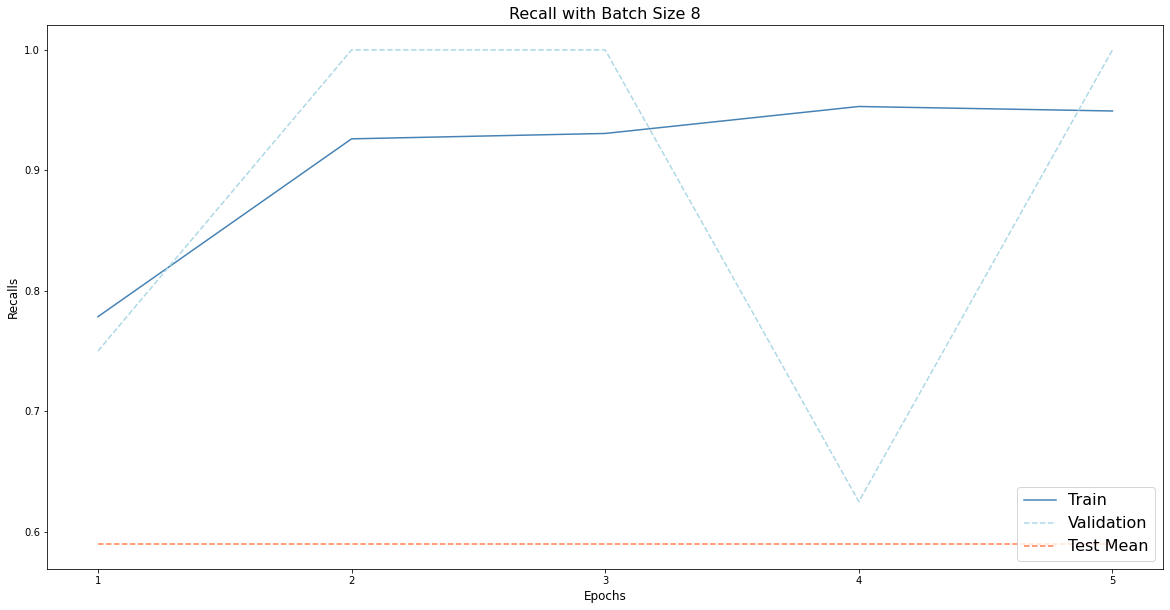

In [ ]:
train_recalls_batch_8 = [0.7785234899328859, 0.9261744966442953, 0.930648769574944, 0.9530201342281879, 0.9492915734526473]
val_recalls_batch_8 = [0.75, 1.0, 1.0, 0.625, 1.0]
test_recalls_batch_8 = [0.5897435897435898] * 5
epochs = [i for i in range(1,5+1)]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax.plot(epochs, train_recalls_batch_8, color="steelblue", label= 'Train')
ax.plot(epochs, val_recalls_batch_8, color="lightblue", ls='dashed', label='Validation')
ax.plot(epochs, test_recalls_batch_8, color= "coral", ls='dashed', label='Test Mean')
ax.set_xticks(epochs)
ax.legend(loc="lower right", fontsize=16)
ax.set_xlabel("Epochs", fontsize=12)
ax.set_ylabel("Recalls", fontsize=12)
ax.set_title("Recall with Batch Size 8", fontsize=16)
plt.show()